# k-Nearest Neighbors

So we have spent a fair amount of time now with our first two models. Both models are fundamentally linear. 

*Linear Regression* is looking for the linear combination of the factors that best produces the result, maximizing the coefficient of prediction $R^2$. 

*Logistic Regression* (which again is classification) is looking for a linear expression in the logistic model that best produces a decision boundary explaining the data. Because the base function is linear this produces decision boundaries that are also linear.

Each of these models can be generalized to nonlinear ones by introducing new features that are transformations of the existing features.

Today we will talk about our first fundamentally non-linear model. These models will introduce additional degrees of freedom that result in models capable of adapting to the training data very closely. Which means then that overfitting becomes much more likely. What we will see is that there is a definite trade off between the complexity or freedom given to our model and the possibility of overfitting.

The k-Nearest Neighbors model will start as a classification model and then we will come back later and adapt it to a regression problem. This will also be the model that I will ask you and your team to write an algorithm for as part of class. Today we will use the existing tool in scikitlearn.

We'll start with the Kidney Disease dataset.

In [70]:
import pandas as pa
import matplotlib.pyplot as plt
import matplotlib.colors as pltco # A package to help with coloring plots
import seaborn as sn
import numpy as np
import numpy.random as rn

In [121]:
kd = pa.read_csv('Data Sets/Kidney/chronic_kidney_disease.csv', 
                 names=['age', 'bp', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
                        'pus_cell_clumps', 'bacteria', 'blood_glucose', 'blood_urea', 'serum_creatinine', 
                        'sodium', 'potassium', 'hemoglobin', 'packed_cell_volume', 'white_blood_cell_count',
                        'red_blood_cell_count', 'hypertension', 'diabetes_mellitus', 'coronary_artery_disease',
                        'appetite', 'pedal_edema', 'anemia', 'class'])

kd.loc[kd.loc[:, 'class'] == 'ckd\t', 'class'] = 'ckd'  # There is an extra tab character on some of the ckd values

kd.head()

,age,bp,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,pedal_edema,anemia,class
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,...,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [122]:
# There are some missing values for hemoglobin and blood pressure

kd = kd[kd.hemoglobin != '?']
kd = kd[kd.bp != '?']

In [123]:
# Many of the numerical values were read as strings so we have to convert the ones we want to use

# Which by the way produces an error in Seaborn.pairplot

for k in kd.index:
    kd.loc[k, 'hemoglobin'] = float(kd.loc[k, 'hemoglobin'])
    kd.loc[k, 'bp'] = int(kd.loc[k, 'bp'])

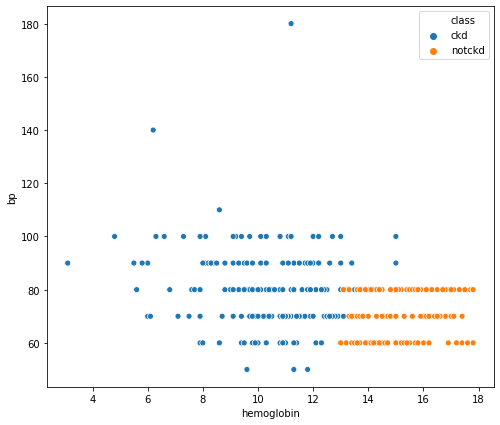

In [124]:
plt.figure(figsize=(8, 7))
sn.scatterplot(x='hemoglobin', y='bp', hue='class', data=kd);

plt.savefig('11.1.png')

The idea for the model is to use the nearby training data to determine what class a point in this coordinate system should be classified as. I.e. given a (hemoglobin, age) pair, we use the $k$-nearest points to that pair to determine the classification at the point. How do they decide, well we let them vote and majority determines the value. Ties will happen, but only along small dimensional subsets so they do not effectively matter.

The smaller $k$ is the more our model will adapt to the training data. When $k=1$ the model uses the classification of the closest point from the training data.

In [125]:
# Set our numpy array from the dataframe

X = np.array(kd[['hemoglobin', 'bp']])
kd['class'] = kd['class'].map({'ckd':1, 'notckd':0, 1:1, 0:0})  # Recode the result feature to be numeric; 
# note the second two values in the dictionary are in case we run this block again

y = np.array(kd[['class']]).reshape(-1)  # had to reshape it to be a vector and not a matrix

In [126]:
# Make the training and testing sets

n = X.shape[0]
test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
perm = rn.permutation(n)   
X = X[perm]
y = y[perm]
X_test = X[:test]       # Then create the test
y_test = y[:test]
X_train = X[test:]     # and train sets
y_train = y[test:]

In [127]:
# Load the classifier from scikitlearn

from sklearn.neighbors import KNeighborsClassifier

In [128]:
clf1 = KNeighborsClassifier(n_neighbors=1) # Define the model
clf1.fit(X_train, y_train);

In [131]:
# A bit of code for plotting the decision boundaries in a categorical problem with two predictors and two values for the result
# Also prints out the training and testing errors

def plot_cat_model(clf, X_train, y_train, X_test, y_test):

    h = 0.1 # Mesh size  
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, 185
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    cmap_light = pltco.ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = pltco.ListedColormap(['#FF0000', '#00FF00'])
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light);

    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold,marker='o')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, marker='+');
    
    print('Training Error: {}'.format(clf.score(X_train, y_train)))
    print('Testing Error: {}'.format(clf.score(X_test, y_test)))

Training Error: 0.959409594095941
Testing Error: 0.9402985074626866


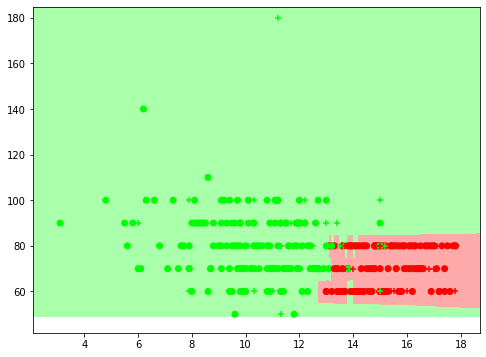

In [132]:
plot_cat_model(clf1, X_train, y_train, X_test, y_test)
plt.savefig('11.2.png')

Note the evidence of overfitting: rapid changes in the boundary and islands. As we increase $k$ the model becomes more rigid and therefore less prone to overfitting. 

Training Error: 0.9520295202952029
Testing Error: 0.9402985074626866


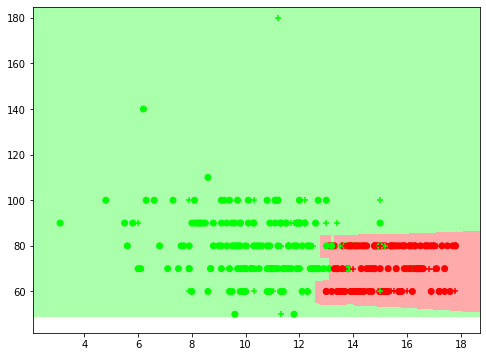

In [133]:
clf2 = KNeighborsClassifier(n_neighbors=2) # Define the model
clf2.fit(X_train, y_train)
plot_cat_model(clf2, X_train, y_train, X_test, y_test)
plt.savefig('11.3.png')

Training Error: 0.9520295202952029
Testing Error: 0.9402985074626866


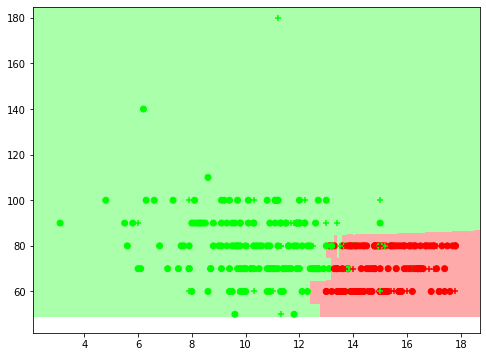

In [134]:
clf3 = KNeighborsClassifier(n_neighbors=7) # Define the model
clf3.fit(X_train, y_train)
plot_cat_model(clf3, X_train, y_train, X_test, y_test)
plt.savefig('11.4.png')

Note that it does give a model that seems to have some features missed by the Logistic Regression model.

Training Error: 0.9520295202952029
Testing Error: 0.9253731343283582


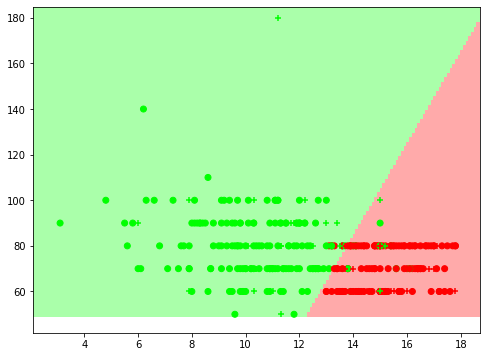

In [135]:
# Compared to a logistic model on the same data
from sklearn.linear_model import LogisticRegression
lgm = LogisticRegression(solver='lbfgs', multi_class='auto').fit(X_train, y_train)
plot_cat_model(lgm, X_train, y_train, X_test, y_test)
plt.savefig('11.5.png')

### Checking Performance with Bootstraps

Applying the bootstrap method we can compare the choices of $k$ across many training sets.

In [136]:
num = 60 # number of bootstraps to use
Xboot = [0]*num
yboot = [0]*num

n = X.shape[0]
for s in range(num):
    sample = np.random.randint(0, n, n)  # Note here starting with a random permutation is not necessary
    Xboot[s] = X[sample, :]
    yboot[s] = y[sample]

In [137]:
test = int(0.20*n)
maxk = 20

labels = [ ['train_{}'.format(x), 'test_{}'.format(x)] for x in range(1, maxk+1)]
labels = [x for sublist in labels for x in sublist]

Error = pa.DataFrame(  np.array([0]*num*2*maxk).reshape(num, 2*maxk), columns = labels)

for s in range(num):
    X_test = Xboot[s][:test]
    y_test = yboot[s][:test]
    X_train = Xboot[s][test:]
    y_train = yboot[s][test:]
    
    for k in range(maxk):
        clf = KNeighborsClassifier(n_neighbors=k+1) # Define the model
        clf.fit(X_train, y_train) # Train the model
        Error.iloc[s, 2*k] = clf.score(X_train, y_train) 
        Error.iloc[s, 2*k+1] = clf.score(X_test, y_test)
      
Error_mean = [0]*2*maxk
Error_std = [0]*2*maxk
for c in range(2*maxk):
    Error_mean[c] = np.mean(Error.iloc[:num, c])
    Error_std[c] = np.std(Error.iloc[:num, c])
    
Error = Error.append( pa.Series(Error_mean, index=Error.columns), ignore_index=True)
Error = Error.append( pa.Series(Error_std, index=Error.columns), ignore_index=True)
Error.index = list(range(num)) + ['Mean', 'Standard Deviation']
Error.tail()

,train_1,test_1,train_2,test_2,train_3,test_3,train_4,test_4,train_5,test_5,...,train_16,test_16,train_17,test_17,train_18,test_18,train_19,test_19,train_20,test_20
57,0.974170,0.955224,0.952030,0.940299,0.966790,0.955224,0.944649,0.970149,0.948339,0.985075,...,0.944649,0.955224,0.933579,0.955224,0.933579,0.955224,0.933579,0.955224,0.933579,0.955224
58,0.952030,0.910448,0.959410,0.910448,0.963100,0.925373,0.952030,0.910448,0.955720,0.925373,...,0.937269,0.895522,0.929889,0.880597,0.944649,0.910448,0.944649,0.895522,0.933579,0.895522
59,0.985240,1.000000,0.963100,0.940299,0.966790,0.955224,0.944649,0.925373,0.940959,0.925373,...,0.933579,0.925373,0.937269,0.925373,0.937269,0.925373,0.937269,0.925373,0.940959,0.925373
Mean,0.971341,0.947761,0.965621,0.946020,0.967528,0.947264,0.959533,0.945522,0.960025,0.944030,...,0.942989,0.931592,0.942066,0.930597,0.940283,0.929104,0.941021,0.929851,0.939483,0.928607
Standard Deviation,0.012040,0.029159,0.009323,0.024539,0.009475,0.025044,0.011393,0.027362,0.011256,0.025798,...,0.014674,0.037093,0.014719,0.036643,0.015207,0.035175,0.015778,0.034501,0.017532,0.036365


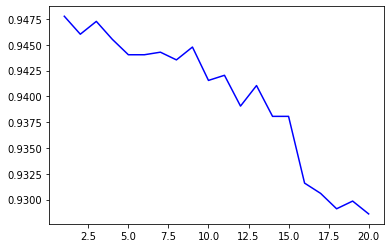

In [138]:
# Let's plot the testing error means as a function of k

testing_error = Error_mean[1::2]  # Grabing every other item from the Error means
kk = range(1, maxk+1)
plt.plot(kk, testing_error, 'b-');
plt.savefig('11.6.png')

In this case at least see that increasing $k$ produces a less flexible model that is less frequently overfit to the training data at the expenses of the testing data. 

### Normalization

k-Nearest Neighbors is an algorithm that relies on computing the distances between points in the coordinate plane. As such it is an example of an algorithm that might pereform better on data that has been normalized. One method of normalization is to rescale the data to fit in the interval $[0, 1]$ via

$$ \hat{x}_i = \frac{ x_i - \mbox{min}(x)}{ \mbox{max}(x) - \mbox{min}(x) } $$

In [139]:
# Normalize the values for X; this is needed because we are computing the distance between points so we need the two axis to have the 
# same metric

for l in range(X.shape[1]):
    X[:, l] = ( X[:, l] - min(X[:, l]))/(max(X[:, l]) - min(X[:, l]))

In [140]:
# Make the training and testing sets

n = X.shape[0]
test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
perm = rn.permutation(n)   
X = X[perm]
y = y[perm]
X_test = X[:test]       # Then create the test
y_test = y[:test]
X_train = X[test:]     # and train sets
y_train = y[test:]

In [141]:
# A bit of code for plotting the decision boundaries in a categorical problem with two predictors and two values for the result
# Also prints out the training and testing errors

def plot_cat_model(clf, X_train, y_train, X_test, y_test):

    h = 0.01 # Mesh size  
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = -0.1, 1.1
    y_min, y_max = -0.1, 1.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    cmap_light = pltco.ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = pltco.ListedColormap(['#FF0000', '#00FF00'])
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light);

    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold,marker='o')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, marker='+');
    
    print('Training Error: {}'.format(clf.score(X_train, y_train)))
    print('Testing Error: {}'.format(clf.score(X_test, y_test)))

Training Error: 0.9372693726937269
Testing Error: 0.9850746268656716


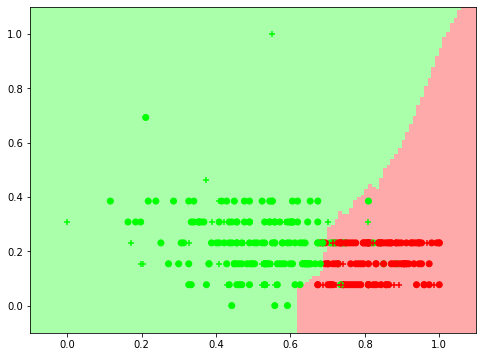

In [142]:
clf2 = KNeighborsClassifier(n_neighbors=10) # Define the model
clf2.fit(X_train, y_train)
plot_cat_model(clf2, X_train, y_train, X_test, y_test)
plt.savefig('11.7.png')

#### Checking the Normalization with Bootstraps

In [143]:
num = 60 # number of bootstraps to use
Xboot = [0]*num
yboot = [0]*num

n = X.shape[0]
for s in range(num):
    sample = np.random.randint(0, n, n)  # Note here starting with a random permutation is not necessary
    Xboot[s] = X[sample, :]
    yboot[s] = y[sample]

In [144]:
test = int(0.20*n)
maxk = 20

labels = [ ['train_{}'.format(x), 'test_{}'.format(x)] for x in range(1, maxk+1)]
labels = [x for sublist in labels for x in sublist]

Error = pa.DataFrame(  np.array([0]*num*2*maxk).reshape(num, 2*maxk), columns = labels)

for s in range(num):
    X_test = Xboot[s][:test]
    y_test = yboot[s][:test]
    X_train = Xboot[s][test:]
    y_train = yboot[s][test:]
    
    for k in range(maxk):
        clf = KNeighborsClassifier(n_neighbors=k+1) # Define the model
        clf.fit(X_train, y_train) # Train the model
        Error.iloc[s, 2*k] = clf.score(X_train, y_train) 
        Error.iloc[s, 2*k+1] = clf.score(X_test, y_test)
      
Error_mean = [0]*2*maxk
Error_std = [0]*2*maxk
for c in range(2*maxk):
    Error_mean[c] = np.mean(Error.iloc[:num, c])
    Error_std[c] = np.std(Error.iloc[:num, c])
    
Error = Error.append( pa.Series(Error_mean, index=Error.columns), ignore_index=True)
Error = Error.append( pa.Series(Error_std, index=Error.columns), ignore_index=True)
Error.index = list(range(num)) + ['Mean', 'Standard Deviation']
Error.tail()

,train_1,test_1,train_2,test_2,train_3,test_3,train_4,test_4,train_5,test_5,...,train_16,test_16,train_17,test_17,train_18,test_18,train_19,test_19,train_20,test_20
57,0.963100,0.925373,0.952030,0.940299,0.955720,0.895522,0.955720,0.910448,0.952030,0.880597,...,0.911439,0.925373,0.911439,0.925373,0.911439,0.910448,0.911439,0.910448,0.911439,0.925373
58,0.977860,0.955224,0.966790,0.955224,0.977860,0.955224,0.963100,0.955224,0.970480,0.955224,...,0.955720,0.970149,0.959410,0.970149,0.955720,0.970149,0.952030,0.970149,0.952030,0.970149
59,0.963100,0.910448,0.966790,0.955224,0.966790,0.970149,0.948339,0.955224,0.948339,0.955224,...,0.952030,0.940299,0.948339,0.940299,0.948339,0.940299,0.948339,0.955224,0.948339,0.955224
Mean,0.970787,0.939055,0.964453,0.943035,0.965375,0.937811,0.957196,0.940299,0.957626,0.940050,...,0.942005,0.936567,0.941882,0.937562,0.940529,0.936318,0.940098,0.935323,0.938438,0.934328
Standard Deviation,0.012999,0.026878,0.009739,0.028383,0.010352,0.030850,0.010376,0.030222,0.010534,0.029411,...,0.015540,0.030905,0.015224,0.030889,0.015320,0.030693,0.015632,0.029180,0.015575,0.030733


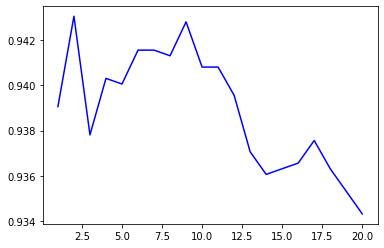

In [145]:
# Let's plot the testing error means as a function of k

testing_error = Error_mean[1::2]  # Grabing every other item from the Error means
kk = range(1, maxk+1)
plt.plot(kk, testing_error, 'b-');
plt.savefig('11.8.png')

### k-Nearest Neighbors with Many Factors

We will skip producing graphs for these cases, but we can develop the model using more factors, and in this case at least we start getting some better predictions.

In [146]:
# There are some missing values for age

kd = kd[kd.age != '?']
kd = kd[kd.specific_gravity != '?']

In [147]:
# Many of the numerical values were read as strings so we have to convert the ones we want to use

for k in kd.index:
    kd.loc[k, 'age'] = float(kd.loc[k, 'age'])
    kd.loc[k, 'specific_gravity'] = float(kd.loc[k, 'specific_gravity'])

In [148]:
# Set our numpy array from the dataframe

X = np.array(kd[['hemoglobin', 'bp', 'age', 'specific_gravity']])
kd['class'] = kd['class'].map({'ckd':1, 'notckd':0, 1:1, 0:0})  # Recode the result feature to be numeric; 
# note the second two values in the dictionary are in case we run this block again

y = np.array(kd[['class']]).reshape(-1)  # had to reshape it to be a vector and not a matrix

In [149]:
# Normalize the values for X; this is needed because we are computing the distance between points so we need the two axis to have the 
# same metric

for l in range(X.shape[1]):
    X[:, l] = ( X[:, l] - min(X[:, l]))/(max(X[:, l]) - min(X[:, l]))

In [150]:
num = 100 # number of bootstraps to use
Xboot = [0]*num
yboot = [0]*num

n = X.shape[0]
for s in range(num):
    sample = np.random.randint(0, n, n)  # Note here starting with a random permutation is not necessary
    Xboot[s] = X[sample, :]
    yboot[s] = y[sample]

In [151]:
test = int(0.20*n)
maxk = 20

labels = [ ['train_{}'.format(x), 'test_{}'.format(x)] for x in range(1, maxk+1)]
labels = [x for sublist in labels for x in sublist]

Error = pa.DataFrame(  np.array([0]*num*2*maxk).reshape(num, 2*maxk), columns = labels)

for s in range(num):
    X_test = Xboot[s][:test]
    y_test = yboot[s][:test]
    X_train = Xboot[s][test:]
    y_train = yboot[s][test:]
    
    for k in range(maxk):
        clf = KNeighborsClassifier(n_neighbors=k+1) # Define the model
        clf.fit(X_train, y_train) # Train the model
        Error.iloc[s, 2*k] = clf.score(X_train, y_train) 
        Error.iloc[s, 2*k+1] = clf.score(X_test, y_test)
      
Error_mean = [0]*2*maxk
Error_std = [0]*2*maxk
for c in range(2*maxk):
    Error_mean[c] = np.mean(Error.iloc[:num, c])
    Error_std[c] = np.std(Error.iloc[:num, c])
    
Error = Error.append( pa.Series(Error_mean, index=Error.columns), ignore_index=True)
Error = Error.append( pa.Series(Error_std, index=Error.columns), ignore_index=True)
Error.index = list(range(num)) + ['Mean', 'Standard Deviation']
Error.tail()

,train_1,test_1,train_2,test_2,train_3,test_3,train_4,test_4,train_5,test_5,...,train_16,test_16,train_17,test_17,train_18,test_18,train_19,test_19,train_20,test_20
97,1.0,0.966667,0.987500,0.933333,0.987500,0.933333,0.958333,0.916667,0.975000,0.933333,...,0.950000,0.916667,0.954167,0.916667,0.945833,0.900000,0.958333,0.916667,0.950000,0.916667
98,1.0,0.983333,1.000000,0.983333,1.000000,0.983333,0.983333,0.966667,0.987500,0.966667,...,0.950000,0.933333,0.958333,0.933333,0.945833,0.916667,0.954167,0.933333,0.954167,0.916667
99,1.0,1.000000,0.991667,0.983333,0.991667,0.983333,0.966667,0.950000,0.966667,0.933333,...,0.945833,0.983333,0.945833,0.983333,0.925000,0.950000,0.925000,0.950000,0.912500,0.950000
Mean,1.0,0.980667,0.985958,0.965333,0.988458,0.968833,0.974000,0.957833,0.978167,0.962667,...,0.948000,0.941500,0.951958,0.945667,0.946833,0.939667,0.949792,0.942333,0.945125,0.938000
Standard Deviation,0.0,0.018062,0.006199,0.024345,0.005976,0.021814,0.009950,0.025761,0.008997,0.024734,...,0.012240,0.032871,0.011851,0.032713,0.012979,0.034382,0.012875,0.032696,0.012721,0.033918


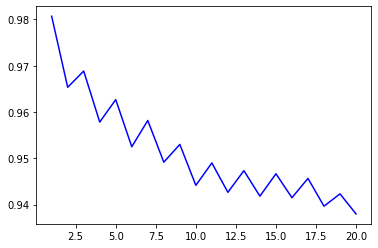

In [152]:
# Let's plot the testing error means as a function of k

testing_error = Error_mean[1::2]  # Grabing every other item from the Error means
kk = range(1, maxk+1)
plt.plot(kk, testing_error, 'b-');
plt.savefig('11.9.png')

## k-Nearest Neighbors for Regression

The idea can be adapted to regression problems by changing from voting for the classification to *interpolating* the values of the result from the $k$-closest training points. The following is a dataset from experiments on the *Compressive Strength* of concrete given parameters in its mix and its age. The problelm here is predict the *Compressive Strength* from the other features.

In [153]:
cp = pa.read_csv('Data Sets/Concrete Data.csv')

cp.head()

,Cement,Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age,Compressive_Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


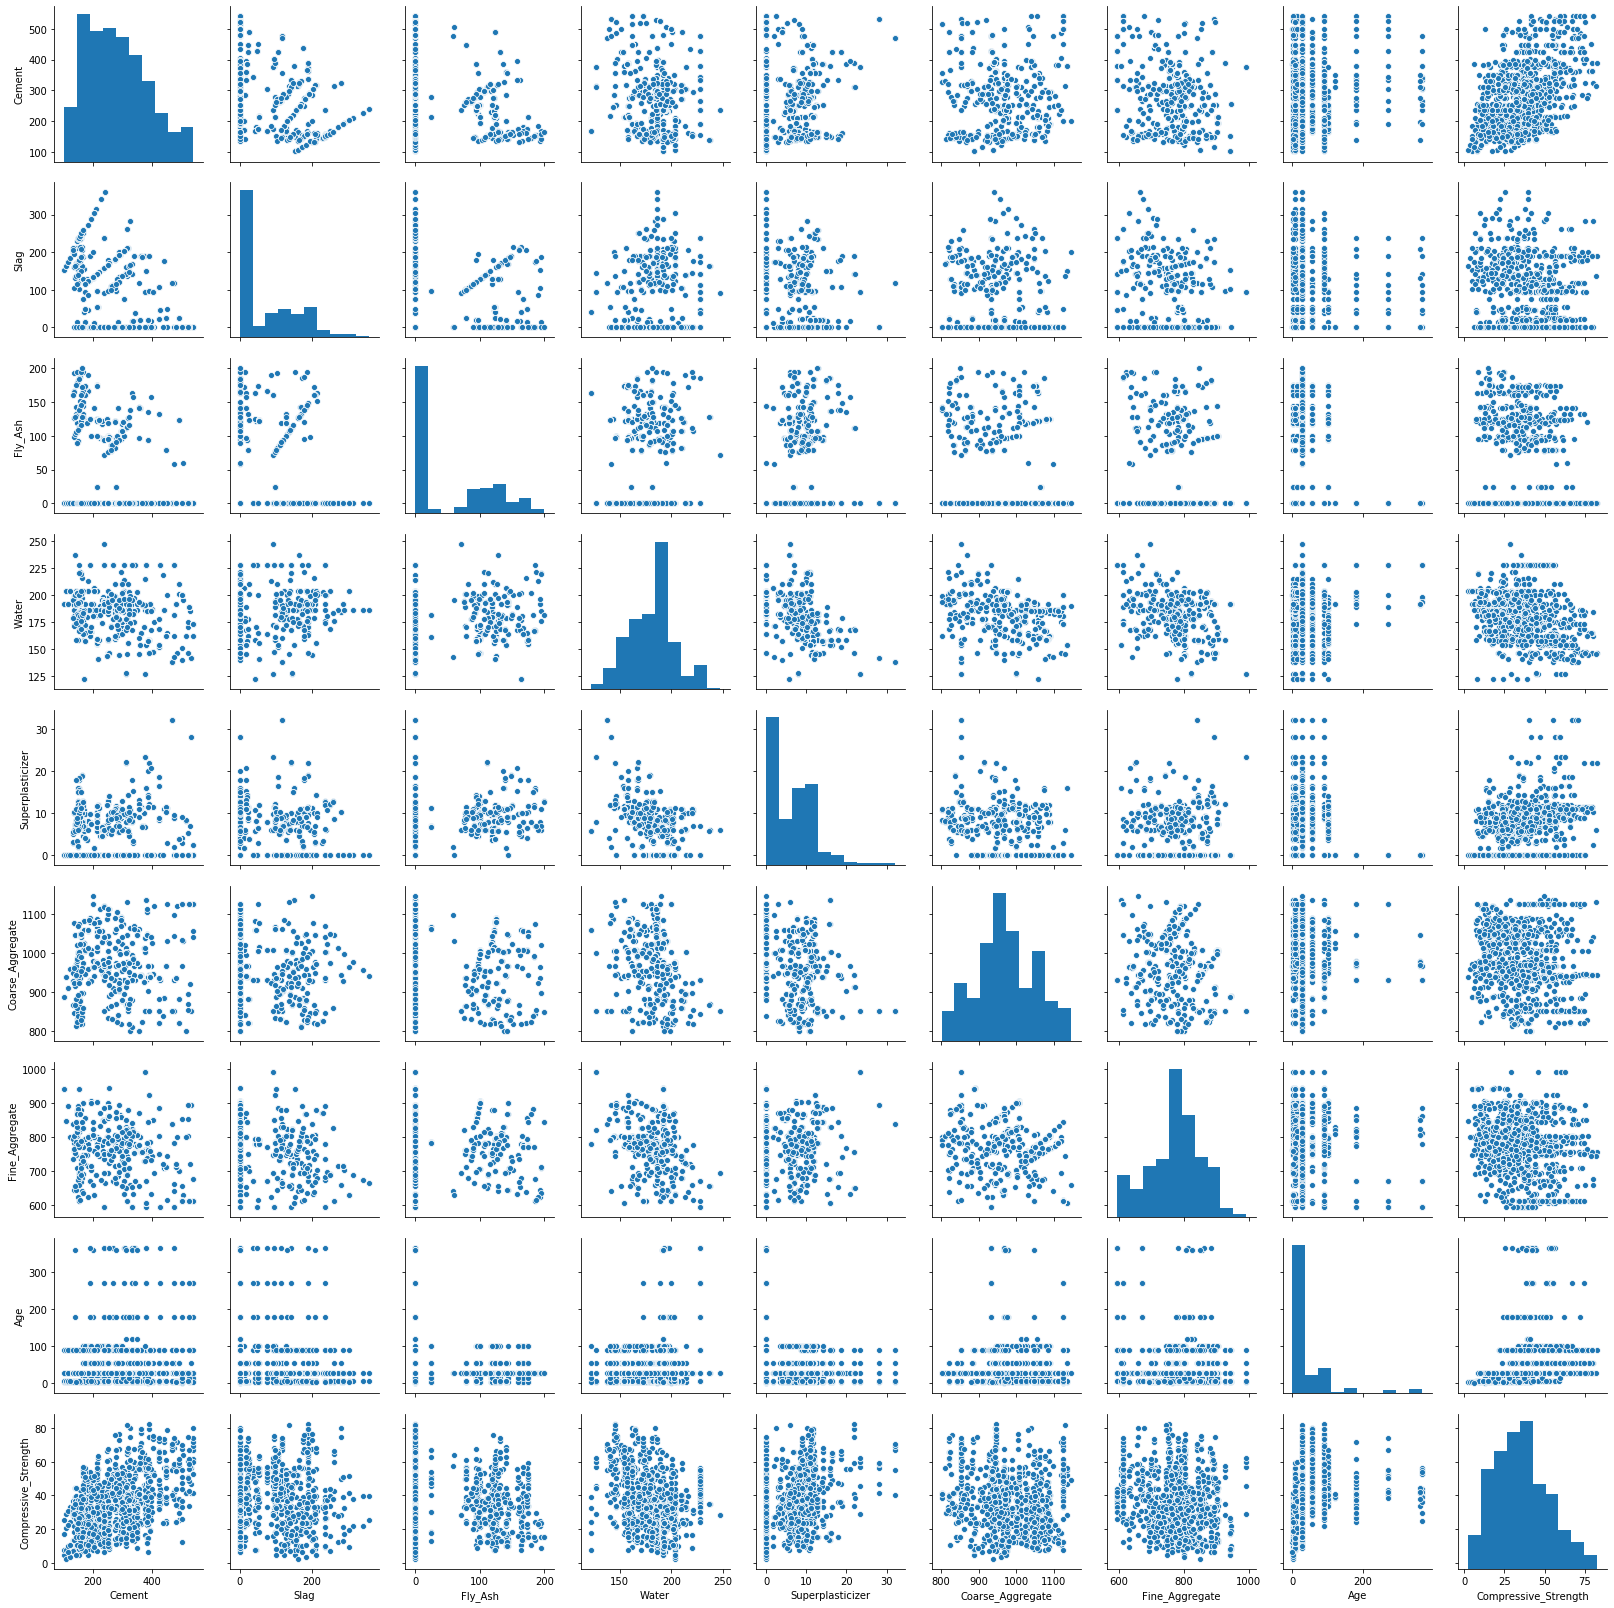

In [154]:
sn.pairplot(cp)
plt.savefig('11.10.png')

In [155]:
X = np.array(cp[['Cement', 'Fine_Aggregate']])
y = np.array(cp.iloc[:, -1])

In [156]:
# Normalize the values for X; this is needed because we are computing the distance between points so we need the two axis to have the 
# same metric

for l in range(X.shape[1]):
    X[:, l] = ( X[:, l] - min(X[:, l]))/(max(X[:, l]) - min(X[:, l]))

In [157]:
# Make the training and testing sets

n = X.shape[0]
test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
perm = rn.permutation(n)   
X = X[perm]
y = y[perm]
X_test = X[:test]       # Then create the test
y_test = y[:test]
X_train = X[test:]     # and train sets
y_train = y[test:]

In [158]:
from sklearn.neighbors import KNeighborsRegressor # Import the Regressor

In [159]:
# A bit of code for plotting the contour in a regression problem with two predictors
# Also prints out the training and testing errors

def plot_reg_model(reg, X_train, y_train, X_test, y_test):

    h = 0.01 # Mesh size  
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = -0.1, 1.1
    y_min, y_max = -0.1, 1.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h))
    Z = reg.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contour(xx, yy, Z)
    
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='+');
    
    print('Training R2: {}'.format(reg.score(X_train, y_train)))
    print('Testing R2: {}'.format(reg.score(X_test, y_test)))

Training R2: 0.32567164411939764
Testing R2: -0.12362575935062914


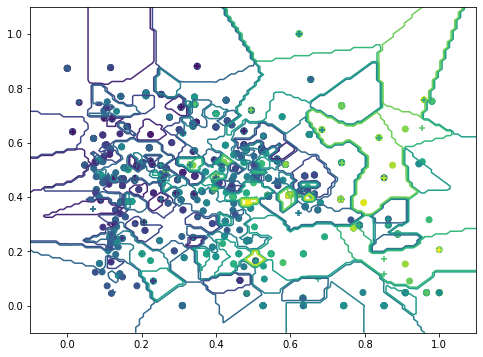

In [160]:
reg = KNeighborsRegressor(n_neighbors=1)
reg.fit(X_train, y_train)
plot_reg_model(reg, X_train, y_train, X_test, y_test)
plt.savefig('11.11.png')

Training R2: 0.4402129712512749
Testing R2: 0.3617271610347551


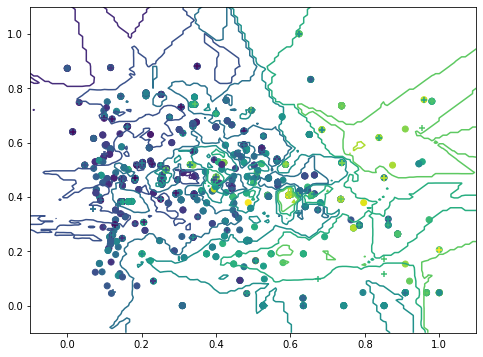

In [161]:
reg = KNeighborsRegressor(n_neighbors=10)
reg.fit(X_train, y_train)
plot_reg_model(reg, X_train, y_train, X_test, y_test)
plt.savefig('11.12.png')

Training R2: 0.3577256982540425
Testing R2: 0.38541798392748905


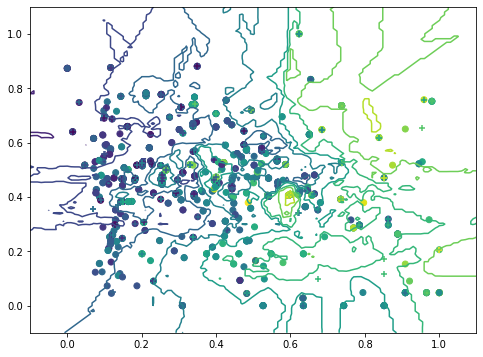

In [162]:
reg = KNeighborsRegressor(n_neighbors=20)
reg.fit(X_train, y_train)
plot_reg_model(reg, X_train, y_train, X_test, y_test)
plt.savefig('11.13.png')

Again we see that for small values of $k$ the model is adapting too closely to the training data and produces results that have overfit. Note the models that result are much more complicated than the *Linear Regression* model.

In [163]:
from sklearn.linear_model import LinearRegression

Training R2: 0.2283714922614799
Testing R2: 0.3384500201239915


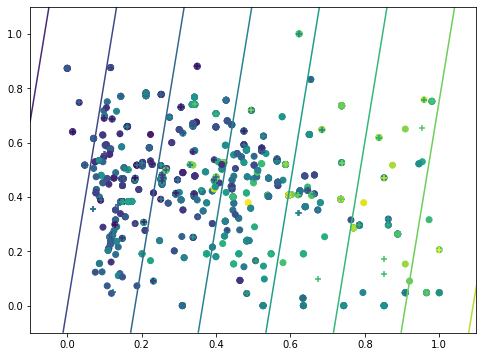

In [164]:
reg = LinearRegression().fit(X_train, y_train)
plot_reg_model(reg, X_train, y_train, X_test, y_test)
plt.savefig('11.14.png')

None of these models is giving a great prediction of the *compressive strength*. The k-Nearest Neighbors do seem to be able to capture some of the points in the interior of the region that have higher strengths, but the degree of nonlinearity we are getting should make us nervous about overfitting. Further analysis is needed, both cross validation of these models, and the application of additional models.